 This file contains functions that can be easily used for other parts of the experiment.
 To make new data mods, duplicate this file and add a new function to replace "basic_preprocessing" in this pipeline.

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
%cd /content/drive/MyDrive/Colab_Notebooks/BME 548/bme-reptile-identification

/content/drive/MyDrive/Colab_Notebooks/BME 548/bme-reptile-identification


In [63]:
# from ipynb.fs.full.create_dataframe import read_data
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from random import choice,sample

In [43]:
def show_images(image_list):
    for i in image_list:
        plt.imshow(i)
        plt.pause(0.5)

def convertToArray(image_list):
    image_array_list=[]
    for i in image_list:
        image_array_list.append(np.asarray(i))
    return pd.Series(image_array_list)

def convertToImage(image_array_list):
    image_list=[]
    for i in image_array_list:
        image_list.append(Image.fromarray(i))
    return pd.Series(image_list)

def read_data(remove_types):

    reptiles=pd.DataFrame()

    reptile_file=os.listdir("data/reptiles")
    for i in reptile_file:
        rep_list=[]
        if (i != ".DS_Store"):
            for j in os.listdir("data/reptiles/"+i):
                if (j != ".DS_Store"):
                    if len(rep_list)<500:
                        rep_list.append(Image.open("data/reptiles/"+i+"/"+j).convert("RGBA"))
        
            rep_list=convertToArray(rep_list)
            df=pd.DataFrame({"image":rep_list})

            df["target"]=i
            reptiles=pd.concat([reptiles,df])

    #remove_types=["Lizard","Toad"]
    reptiles=reptiles[reptiles["target"].isin(remove_types)==False]
    return reptiles.reset_index()


In [44]:
# create dataframe using other file's code
reptiles=read_data(["Lizard","Toad"])
reptiles.target.value_counts()

Snake                  500
Turtle_Tortoise        500
Crocodile_Alligator    500
Frog                   498
Salamander             468
Iguana                 466
Chameleon              390
Gecko                  297
Name: target, dtype: int64

In [45]:
def basic_preprocess(dataframe):
    # Basic preprocessing 

    # prepare X
    img_list = list(dataframe['image'])
    data_img = []
    for each in img_list:
                each_img = cv2.cvtColor(each, cv2.COLOR_BGR2RGB)
                #Resize the images:
                each_img_resized = cv2.resize(each_img, (128,128))
                #Save arrays to a list:
                data_img.append(each_img_resized)
    # Converting list to numpy array
    X = np.array(data_img)

    # prepare y
    y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(dataframe['target'].values.reshape(-1,1))

    return X,y


In [46]:
s=3500
reptiles["target"][s]

'Chameleon'

In [47]:
# y[s]

In [48]:
X,y= basic_preprocess(reptiles) ## replace this to change preprocessing

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)


X_train shape:  (2460, 128, 128, 3)
y_train shape:  (2460, 8)
X_val shape  :  (616, 128, 128, 3)
y_val shape  :  (616, 8)
X_test shape :  (543, 128, 128, 3)
y_test shape :  (543, 8)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [49]:
def fit_model(X_train,y_train,X_val):
    #  code adapted from:
    #  https://pub.towardsai.net/multiclass-image-classification-hands-on-with-keras-and-tensoflow-e1cf434f3467


    train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
    validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)
    train_gen.fit(X_train)
    validation_gen.fit(X_val)
    batch_size = 64
    epochs = 10
    base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=(128,128,3))
    x = base.output
    x = GlobalAveragePooling2D()(x)
    head = Dense(y_train.shape[1], activation='softmax')(x)
    model = Model(inputs=base.input, outputs=head)
    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)
    
    fit = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = epochs,
               validation_data = validation_gen.flow(X_val, y_val)
)

    return model,fit

In [50]:
model,fit=fit_model(X_train,y_train,X_val)

<ipython-input-49-f17f73c0c6cd>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(


Epoch 1/10
39/39 [==============================] - 40s 409ms/step - loss: 1.9255 - accuracy: 0.2736 - val_loss: 1.7551 - val_accuracy: 0.3620
Epoch 2/10
39/39 [==============================] - 16s 403ms/step - loss: 1.4331 - accuracy: 0.5240 - val_loss: 1.2525 - val_accuracy: 0.5877
Epoch 3/10
39/39 [==============================] - 16s 400ms/step - loss: 1.0839 - accuracy: 0.6390 - val_loss: 1.0728 - val_accuracy: 0.6672
Epoch 4/10
39/39 [==============================] - 16s 402ms/step - loss: 0.9122 - accuracy: 0.7024 - val_loss: 0.8848 - val_accuracy: 0.7110
Epoch 5/10
39/39 [==============================] - 16s 400ms/step - loss: 0.7711 - accuracy: 0.7496 - val_loss: 0.9408 - val_accuracy: 0.7224
Epoch 6/10
39/39 [==============================] - 16s 402ms/step - loss: 0.7341 - accuracy: 0.7500 - val_loss: 0.7688 - val_accuracy: 0.7484
Epoch 7/10
39/39 [==============================] - 16s 402ms/step - loss: 0.6488 - accuracy: 0.7821 - val_loss: 0.7733 - val_accuracy: 0.7468

In [51]:
def make_plots(model_fit):
    history_df = pd.DataFrame(model_fit.history)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history_df['loss'], label='training loss')
    plt.plot(history_df['val_loss'], label='validation loss')
    plt.title('Model Loss Function')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history_df['accuracy'], label='training accuracy')
    plt.plot(history_df['val_accuracy'], label='validation accuracy')
    plt.title('Model Accuracy')
    plt.legend();

def getPredTestClasses(model):
    y_pred = model.predict(X_test)
    # Converting prediction classes from one hot encoding to list
    # Argmax returns the position of the largest value
    y_pred_classes = np.argmax(y_pred, axis = 1)
    # Convert test labels from one hot encoding to list
    y_test_classes = np.argmax(y_test, axis = 1)
    return y_test_classes,y_pred_classes

def make_conf_matrix(y_test_classes,y_pred_classes):
    # Create the confusion matrix
    confmx = confusion_matrix(y_test_classes, y_pred_classes)
    f, ax = plt.subplots(figsize = (8,8))
    sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show();

17/17 [==============================] - 2s 87ms/step


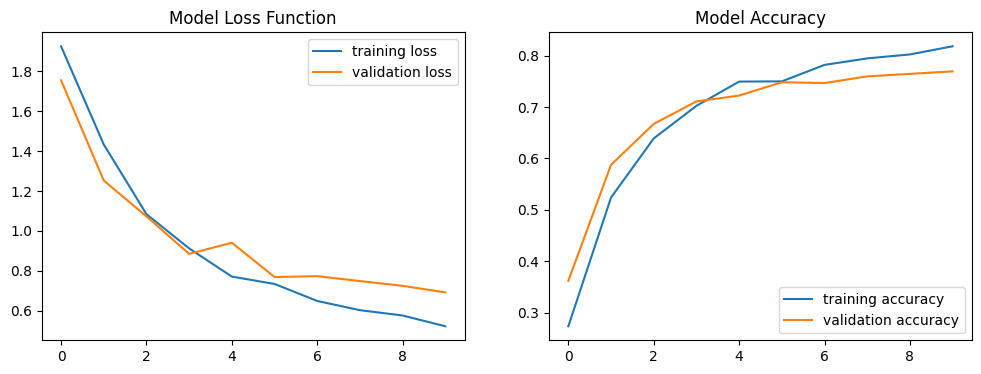

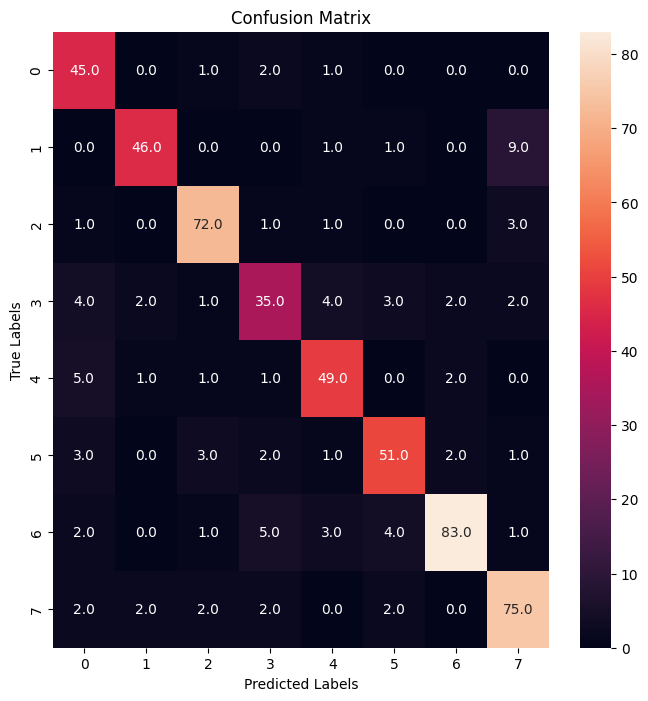

In [52]:
make_plots(fit)

y_test_classes,y_pred_classes= getPredTestClasses(model)
make_conf_matrix(y_test_classes,y_pred_classes)


In [53]:
predicted=pd.DataFrame({"True":y_test_classes,"Pred":y_pred_classes})

# change classes to actual labels
label_key = {0 : 'Chameleon', 1 : 'Crocodile',2:"Frog", 3: 'Gecko', 4 : 'Iguana', 5: 'Salamander', 6:"Snake", 7:"Turtle"}
predicted=predicted.replace({"True": label_key,"Pred":label_key})

In [54]:
def show_sample_misclassified(predicted):
    misclassified=predicted.loc[~(predicted['True'] == predicted['Pred'])]
    indices = sample(misclassified.index.to_list(),8)
    i = 1
    plt.figure(figsize=(14,7))
    for each in indices:
        plt.subplot(2,4,i)
        plt.imshow(Image.fromarray(X_test[each]))
        plt.title("True:"+misclassified['True'].loc[each]+"\nPredicted: "+misclassified['Pred'].loc[each])
        plt.xticks([])
        plt.yticks([])
        i += 1

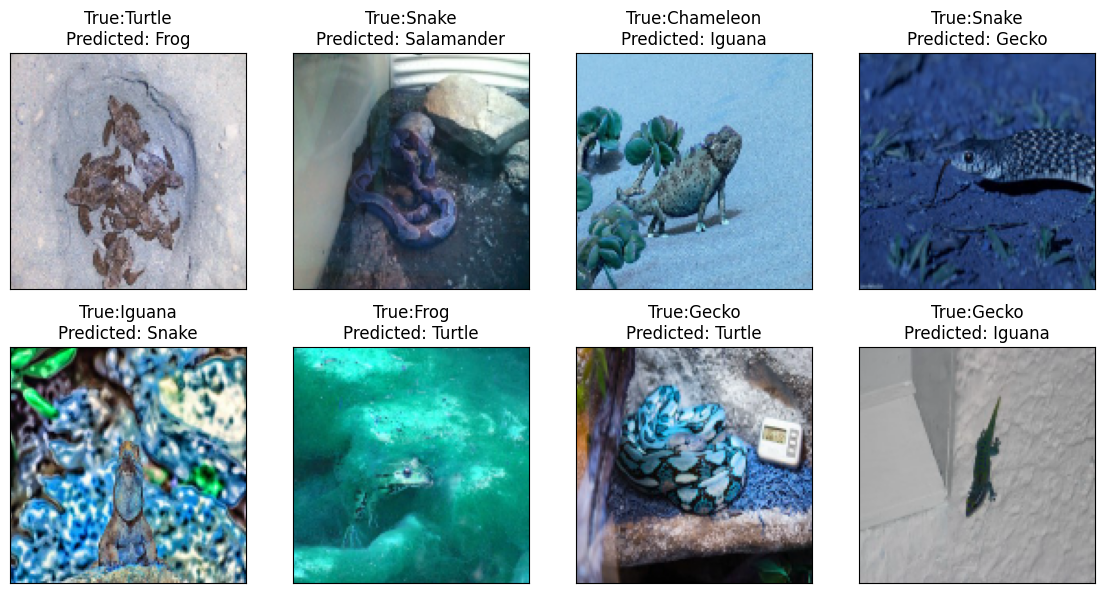

In [55]:
show_sample_misclassified(predicted)

# Changing Aperture

In [211]:
def circle(matrix, radius):
  height = len(matrix[0])
  width = len(matrix[0][0])

  for row in range(height):
    for col in range(width):
      if (height/2 - row)**2 + (width/2 - col)**2 < radius**2:
        matrix[0,row,col] = 1
  return matrix

In [277]:
class physical_layer(tf.keras.layers.Layer):
  def __init__(self):
    super(physical_layer, self).__init__()
    self.circ_aper = tf.Variable(circle(np.zeros((1, 200,300,1)), 50), dtype=tf.dtypes.float32, name='aperture')
    # self.aper_phase = tf.Variable(tf.cast(np.full((200,300, 1), 0.5), tf.dtypes.float32), name='aperture_phase')

  def call(self, input):
    image = tf.cast(input, tf.dtypes.complex64)
    image = tf.signal.fftshift(tf.signal.fft2d(image))
    image = image * tf.exp(1j*tf.cast(self.circ_aper, tf.dtypes.complex64))
    # image = image * tf.exp(1j*tf.cast(self.aper_phase, tf.dtypes.complex64))
    image = tf.signal.ifft2d(tf.signal.ifftshift(image))
    image = tf.abs(image)**2
    # plt.imshow(image)
    return tf.cast(image, tf.dtypes.float32)

(-0.5, 299.5, 199.5, -0.5)

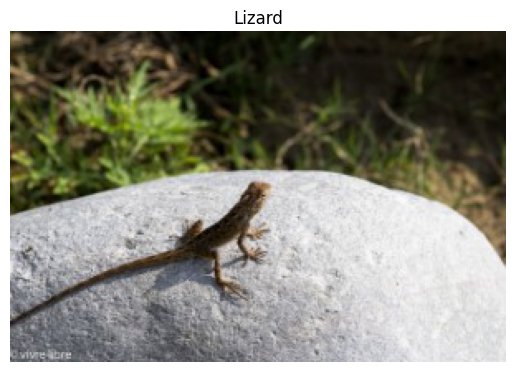

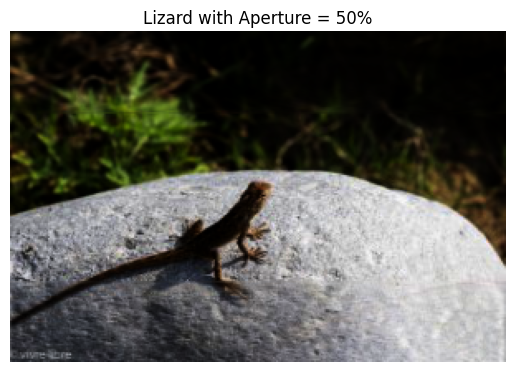

In [278]:
aperture = physical_layer()
img = Image.open("/content/drive/MyDrive/Colab_Notebooks/BME 548/bme-reptile-identification/data/reptiles/Lizard/10573142086_4f1398c293_o.jpg")
img = np.array(img)/255.
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.title('Lizard')
img = aperture.call(img)
img = np.array(img).reshape(200,300,3)
plt.figure()
plt.title('Lizard with Aperture = 50%')
plt.imshow(img)
plt.axis('off')